# Problem 1

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.optimize as opt

def ndNewton(Df, D2f, init_point, maxiter, tol):
    
    crit = tol + 1
    k = 0
    x0 = init_point
    x1 = np.zeros_like(x0) #initialize x1
    while (k<maxiter) and (crit > tol):
        
        #solve for D2f(xk) * zk = Df(xk).T
        z = la.solve(D2f(x0), Df(x0))
        x1 = x0 - z
        crit = la.norm(Df(x1), ord = np.inf)
        x0 = x1
        
        k += 1
        
    return x0, k

#test with rosen function
f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
ndNewton(df, d2f, np.array([2,2]), 50, 1e-6)
    

(array([1., 1.]), 5)

Observe that the result is the same as the analytical result.

# Problem 2 

In [2]:
def bfgs(Df, starting_point, maxiter, tol):
    x0 = starting_point
    n = len(x0)
    A0_m1 = np.eye(n)
    crit = tol + 1
    k = 0
    while (k<maxiter) and (crit > tol):

        #sk = - np.dot(A0_m1, Df(x0))
        x1 = x0 - np.dot(A0_m1, Df(x0))
        sk = x1 - x0

        yk = Df(x1).T - Df(x0).T
     
        #avoid division by zero
        if (np.dot(sk, yk))**2 == 0: return x0, False, maxiter
        
        temp1 = A0_m1 + (np.dot(sk, yk) + np.dot(yk, np.dot(A0_m1, yk))) / (np.dot(sk, yk)**2) * np.outer(sk, sk)
        temp2 = 1/np.dot(sk, yk) * (np.dot(A0_m1, np.outer(yk, sk)) + np.outer(sk, yk) @ A0_m1)
        A0_m1 = temp1 - temp2
        
        crit = la.norm(Df(x1), ord = np.inf)
        x0 = x1
        k+=1
    

    if crit >= tol:
        conv = False
    else:
        conv = True
    #print(conv)
    
    return x0, conv, k

f = opt.rosen
df = opt.rosen_der
d2f = opt.rosen_hess
bfgs(df, np.array([-2,-4]), 400, 1e-6)

(array([1.00000002, 1.00000004]), True, 141)

Observe that the result is the same as the analytical result.

# Problem 3

In [3]:
import time
import matplotlib.pyplot as plt
def p3(N):
    
    newton_time = np.zeros(N)
    dfgs_time = np.zeros(N)
    scipy_time = np.zeros(N)
    
    newton_itr = np.zeros(N)
    dfgs_itr = np.zeros(N)
    scipy_itr = np.zeros(N)
    
    for i in range(N):
        x, y = np.random.uniform(-3, 3, 2) # sample a point in [-3, 3] * [-3, 3]
        
        # perform newton method
        start_time = time.time()
        res, itr = ndNewton(df, d2f, np.array([x,y]), 50, 1e-6)
        end_time = time.time()
        
        newton_time[i] = end_time - start_time
        newton_itr[i] = itr
        
        # perform dfgs
        start_time = time.time()
        res, status, itr = bfgs(df, np.array([x,y]), 800, 1e-6)
        end_time = time.time()
        
        dfgs_time[i] = end_time - start_time
        dfgs_itr[i] = itr
        
        # perform scipy
        start_time = time.time()
        itr = len(opt.fmin_bfgs(f, [x,y], disp = False, retall = True, gtol = 1e-6)[1])
        end_time = time.time()
        
        scipy_time[i] = end_time - start_time
        scipy_itr[i] = itr
    
    plt.plot(newton_time, newton_itr, "o", markersize = 5, label="Newton's method")
    plt.plot(dfgs_time, dfgs_itr, "o", markersize = 5, label = "BFGS")
    plt.plot(scipy_time, scipy_itr, "o", markersize = 5, label = "scipy.optimize.fmin_bfgs()")
    plt.xscale('log')
    plt.yscale("log")
    plt.xlabel("Time(Seconds)")
    plt.ylabel("Iterations")
    plt.title("Comparison of Newton's method, my dfgs, and scipy's dfgs")
    plt.legend(loc = "upper left")
    plt.show()
    
    
    
  
    

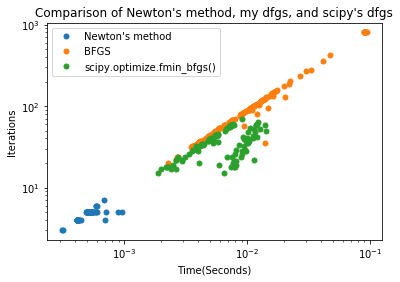

In [4]:
p3(100)

# Problem 4 

In [7]:
# let us fix the perturbation
pert = np.random.randn(10)

In [10]:
def minLeastSq(phi, Dphi, residual, Jacobian, starting_point, maxiter, tol):
    x0 = starting_point
    k = 0
    crit = tol + 1
    
    while (k < maxiter) and (crit > tol):
        x1 = x0 - la.inv((Jacobian(x0).T @ Jacobian(x0))) @ (Jacobian(x0).T @ residual(x0))
        crit = la.norm(x1 - x0, ord = np.inf)
        x0 = x1
        
        k += 1
        
    
    if crit <= tol:
        conv = True
    else:
        conv = False
        
    return x0, k, conv

T = np.arange(10)
y = 3*np.sin(0.5*T) + 0.5 * pert
phi = lambda x, t : x[0]*np.sin(x[1]*t)
residual = lambda x : phi(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))


soln1 = minLeastSq(phi, 2, residual, jac, [2.5, 7], 100, 1e-12)
amplitude, period = soln1[0]
amplitude, period   

(3.1123456197229933, 6.785727794304953)

In [19]:
def array_of_res(param):
    T = np.arange(10)
    truth = 3*np.sin(0.5*T) + 0.5 * pert
    A = param[0]
    w = param[1]
    model = A * np.sin(w*T)
    res = model - truth
    return res

soln2 = opt.leastsq(array_of_res, np.array([3, 0.5]))
soln2

(array([3.11234616, 0.50254231]), 1)

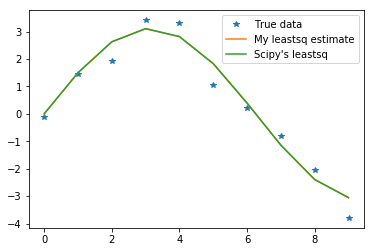

In [22]:
plt.plot(T, y, "*", label = "True data")
plt.plot(T, amplitude*np.sin(period*T), label = "My leastsq estimate")
plt.plot(T, soln2[0][0]*np.sin(soln2[0][1]*T), label = "Scipy's leastsq")
plt.legend()
plt.show()

Observe that the two results match exactly.